In [540]:
import os
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import statsmodels

In [623]:
df = pd.read_csv("masterDF.csv").dropna(subset=["wiki views"])
df.columns = df.columns.map(lambda s: s.replace(" ", "_"))
movies = pickle.load(open("movies.pkl"))

In [624]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 1620
Data columns (total 8 columns):
title               376 non-null object
studio              376 non-null object
gross               376 non-null float64
total_theaters      376 non-null float64
opening_gross       372 non-null float64
opening_theaters    374 non-null float64
release             376 non-null object
wiki_views          376 non-null float64
dtypes: float64(5), object(3)
memory usage: 26.4+ KB


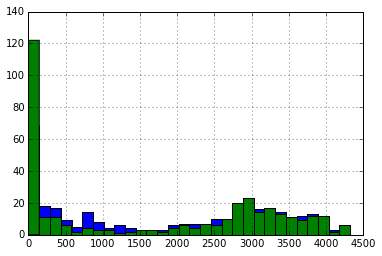

In [644]:
df.total_theaters.hist(bins = 30);
df.opening_theaters.hist(bins=30)

In [641]:
df.sort_values(["total_theaters", "wiki_views"], ascending=True).head(30)

,title,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views
1201,Difret,TA,49667,4,6777,1,2015-10-23,6424
1077,Wolf Totem,Sony,210591,5,NaN,NaN,2015-09-11,16943
608,Before I Disappear,IFC,10078,5,2676,1,2014-11-28,22884
575,A Long Way Down,Magn.,13347,5,1426,1,2014-07-11,44964
576,Camp X-Ray,IFC,13302,7,1316,1,2014-10-17,79530
1579,Aferim!,BWP,99002,8,15892,5,2016-01-22,7831
1316,The Hallow,IFC,13906,8,1559,1,2015-11-06,37164
514,Lilting,Strand,27054,9,1567,1,2014-09-26,11913
444,Hellion,IFC,55708,9,7601,1,2014-06-13,20610
474,Next Goal Wins,KE,43089,10,2568,5,2014-04-25,4643


In [545]:
#ignore opening theaters
df = df[df.opening_theaters > 500]

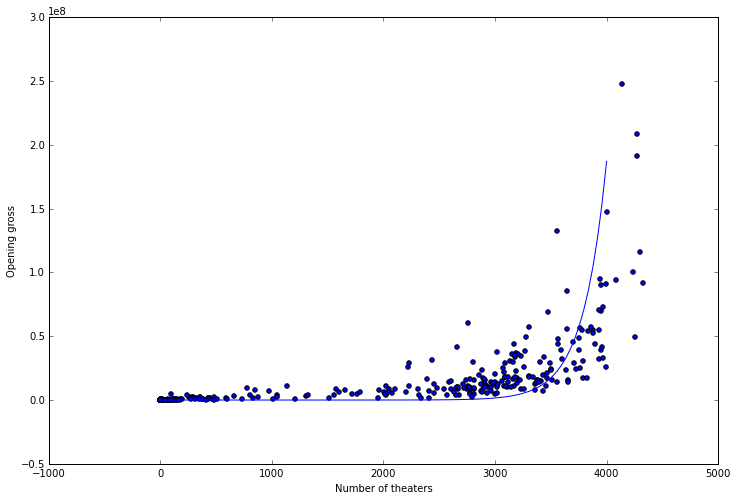

In [628]:
plt.figure(figsize=(12,8))
plt.scatter(df['opening_theaters'], df['opening_gross']);
plt.xlabel("Number of theaters")
plt.ylabel("Opening gross")
#plt.ylim(0, 1e8)
#plt.xlim(0, 4000)

x = np.linspace(0, 4000, 100)
plt.plot(x, np.e**(x/210))
#plt.plot(x, x**2)

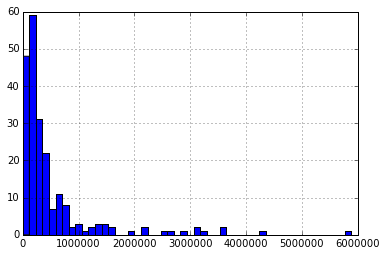

In [550]:
df.wiki_views.hist(bins=50)

In [631]:
df.sort_values("wiki_views").head(10)

,title,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views
1494,How to Be Single,WB,46843513,3357,17878911,3343,2016-02-12,668
916,The End of the Tour,A24,3002884,355,123238,4,2015-07-31,1193
1053,Go Away Mr. Tumor,CL,286639,18,50036,15,2015-08-14,1775
854,Dope,ORF,17506470,2002,6100010,2002,2015-06-19,3104
334,The Breakup Guru,CL,208959,12,62717,12,2014-06-27,3585
170,The Trip to Italy,IFC,2880537,199,71712,3,2014-08-15,3922
1069,20 Once Again,CJ,234573,13,92827,13,2015-01-16,4376
474,Next Goal Wins,KE,43089,10,2568,5,2014-04-25,4643
1033,The Second Mother,Osci.,376986,223,24086,3,2015-08-28,4918
1562,The Masked Saint,Free,182695,482,123839,482,2016-01-08,5738


In [629]:
#ignore opening theaters
df = df[df.wiki_views > 500]

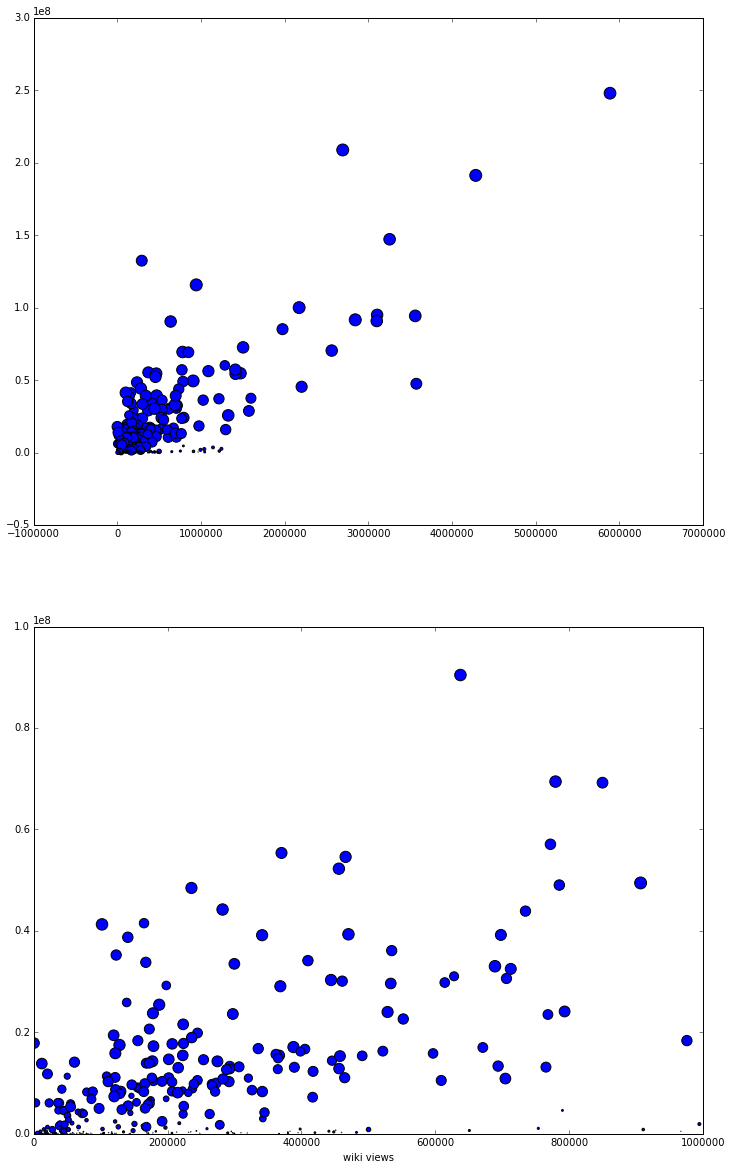

In [635]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))

ax1.scatter(df['wiki_views'], df['opening_gross'], s=df['opening_theaters']/30.)

ax2.scatter(df['wiki_views'], df['opening_gross'], s=df['opening_theaters']/30.)
ax2.set_xlim(0, 1e6); ax2.set_ylim(0, 1e8)
plt.xlabel("wiki views")

In [561]:
import statsmodels.formula.api as sm

In [620]:
temp = df.copy()
model = sm.ols("opening_gross ~  np.power(np.e, opening_theaters/210.) + wiki_views", temp)
fit = model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          opening_gross   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     293.3
Date:                Fri, 22 Apr 2016   Prob (F-statistic):           8.60e-60
Time:                        14:31:26   Log-Likelihood:                -3615.5
No. Observations:                 200   AIC:                             7237.
Df Residuals:                     197   BIC:                             7247.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
Intercept                                8.024e+06   1.47e+06      5.442      0.000      5.12e+06  1.09e+07
np.power(np.e, opening_theaters / 210.)     0.0917      0.012      7.676      0.000         0.068     0.115
wiki_views                                 26.0153      1.894     13.737      0.000        22.281    29.750
==============================================================================
Omnibus:                      107.892   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1323.067
Skew:                           1.723   Prob(JB):                    5.01e-288
Kurtosis:                      15.120   Cond. No.                     1.63e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

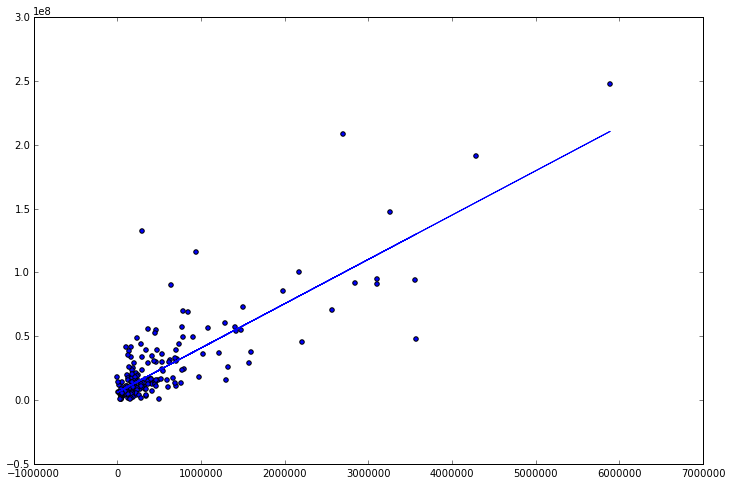

In [610]:
plt.figure(figsize=(12,8))
plt.scatter(df.wiki_views, df.opening_gross)
plt.plot(df.wiki_views, 34.75*df.wiki_views + 2.103e-06*df.wiki_views + 6.039e+06)
#plt.xlim(0, 1e6); plt.ylim(0, 1e8)